In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

def open_chi(path):  
    ds=(xr.open_dataset(path)*100)
    ds=ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds=ds.reindex(lon=sorted(ds.lon))  
    return ds

In [2]:
method_ls = ["ML","MAM4","diff","diff_abs"]
chi_ls = ["chi_b","chi_c","chi_h"]

file_path = {}
file_path["MAM4"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_chi/"
file_path["ML"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/ml_chi/"
file_path["diff"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
file_path["diff_abs"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
mask_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mask/"

name_ls = {}
# name_ls["chi_abd"]=r'$\overline{\chi_{\mathrm{a}}}$'+" (%)"
name_ls["chi_h"]=r'$\overline{\chi_{\mathrm{h}}}$'+" (%)"
name_ls["chi_b"]=r'$\overline{\chi_{\mathrm{o}}}$'+" (%)"
name_ls["chi_c"]=r'$\overline{\chi_{\mathrm{c}}}$'+" (%)"

mam4_name_ls = {}
mam4_name_ls["chi_b"]=r'$\overline{\chi_{\mathrm{o}}^{\mathrm{MAM4}}}$ (%)'
mam4_name_ls["chi_c"]=r'$\overline{\chi_{\mathrm{c}}^{\mathrm{MAM4}}}$ (%)'
mam4_name_ls["chi_h"]=r'$\overline{\chi_{\mathrm{h}}^{\mathrm{MAM4}}}$ (%)'

ml_name_ls = {}
ml_name_ls["chi_b"]=r'$\overline{\chi_{\mathrm{o}}^{\mathrm{ML}}}$ (%)'
ml_name_ls["chi_c"]=r'$\overline{\chi_{\mathrm{c}}^{\mathrm{ML}}}$ (%)'
ml_name_ls["chi_h"]=r'$\overline{\chi_{\mathrm{h}}^{\mathrm{ML}}}$ (%)'

diff_name_ls = {}
# diff_name_ls["chi_abd"]=r'$\overline{\Delta\chi_{\mathrm{a}}}$'+" (%)"
diff_name_ls["chi_h"]=r'$\overline{\Delta\chi_{\mathrm{h}}}$'+" (%)"
diff_name_ls["chi_b"]=r'$\overline{\Delta\chi_{\mathrm{o}}}$'+" (%)"
diff_name_ls["chi_c"]=r'$\overline{\Delta\chi_{\mathrm{c}}}$'+" (%)"

diff_abs_name_ls = {}
# diff_abs_name_ls["chi_abd"]=r'$\overline{|\Delta\chi_{\mathrm{a}}|}$'+" (%)"
diff_abs_name_ls["chi_h"]=r'$\overline{|\Delta\chi_{\mathrm{h}}|}$'+" (%)"
diff_abs_name_ls["chi_b"]=r'$\overline{|\Delta\chi_{\mathrm{o}}|}$'+" (%)"
diff_abs_name_ls["chi_c"]=r'$\overline{|\Delta\chi_{\mathrm{c}}|}$'+" (%)"
char_ls="abcdefghijklmnop"

# Hatch for all figure

  0%|          | 0/4 [00:00<?, ?it/s]/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)

 25%|██▌       | 1/4 [00:28<01:24, 28.13s/it]/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotl

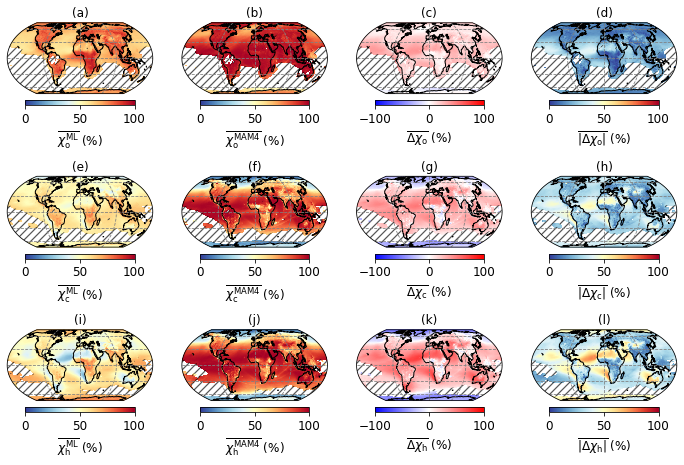

CPU times: user 7min 50s, sys: 8.42 s, total: 7min 59s
Wall time: 7min 48s


In [3]:
%%time
def ax_mesh_hatch(da,mask,nrows,ncols,idx,ax_title,ctext,vmin=0,vmax=100,cmap='RdYlBu_r'):
    ax = plt.subplot(nrows,ncols,idx,projection=ccrs.EqualEarth())
    # plot area with mask
    p = da.where(mask).plot(vmin=vmin,vmax=vmax,
                            cmap=cmap,
                            ax=ax,transform=ccrs.PlateCarree(),
                            add_colorbar=False,rasterized=True)
    # plot inverse mask (using hatch)
    mask_inverse = mask.where(mask==0)
    ax.pcolor(mask_inverse.lon, mask_inverse.lat,
              mask_inverse,hatch="///",alpha=0,
              transform=ccrs.PlateCarree(),
              rasterized=True)

    ax.set_title(ax_title)
    ax.set_global() 
    ax.coastlines()
    cbar = plt.colorbar(p, ax=ax,
                        orientation="horizontal",
                        fraction=0.1,
                        shrink=0.75,
                        pad=0.05,
                        extend="neither")
    cbar.ax.set_xlabel(ctext)
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])
    
#################################    
year = "2011"

rc={'axes.labelsize':12, 'font.size':12, 'legend.fontsize':12, 'axes.titlesize':12}
plt.rcParams.update(**rc)

i=1
fig = plt.figure(figsize=(12,8))
for chi in tqdm(chi_ls):
    for method in tqdm(method_ls):
        if method=="diff_abs":
            da = open_chi(file_path[method]+str(year)+"_"+chi+"_mean_abs.nc")[chi]
            mask = open_chi(mask_path+str(year)+"_"+chi+".nc")["mask"]
            ax_mesh_hatch(da,mask,3,4,i,"("+char_ls[i-1]+")", 
                    diff_abs_name_ls[chi],vmin=0,vmax=100)
        
        else:
            da = open_chi(file_path[method]+str(year)+"_"+chi+"_mean.nc")[chi]
            mask = open_chi(mask_path+str(year)+"_"+chi+".nc")["mask"]
        
            if method=="diff":
                ax_mesh_hatch(da,mask,3,4,i,"("+char_ls[i-1]+")", 
                        diff_name_ls[chi],vmin=-100,vmax=100,cmap="bwr")
            
            elif method=="ML":
                ax_mesh_hatch(da,mask,3,4,i,"("+char_ls[i-1]+")", 
                        ml_name_ls[chi])
            
            else:
                ax_mesh_hatch(da,mask,3,4,i,"("+char_ls[i-1]+")", 
                        mam4_name_ls[chi])

        i+=1
        del da, mask
        gc.collect()
plt.tight_layout()
fig.savefig("../figures/diff_map.pdf",dpi=288)
plt.show()